# XGBoost Overview

XGboost is a gradient boosting algorithm with some tweaks that make it more effective, and faster, than traditional gradient boosting. Most importantly, it uses CART trees and regularization built in to the model which controls model complexity. It also has clever ways of splitting the data which makes it much faster at finding the optimal greedy split per class

## Why XGBoost is effective for this dataset

XGBoost should be effective for this dataset because our decision trees by themselves were quite effective, and XGBoost uses decision trees as the foundation of its prediction. Plus, one of the biggest struggles of this dataset is the class imbalance, but XGBoost has parameters that can easily control the class weights. These impact both the "splits" in our decision tree algorithm and also the importance of each data point, which hopefully balances out the precision/recall of our two classes.

# Preparing the data ...

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data = pd.read_csv('../data/humsavar_dbnsfp53_complete.csv')
# drop irrelevant columns (either too many unique values or 'cheating' as they're based on the label'
data = data.drop(columns=['Gene', 'Entry', 'FTId', 'AA_change', 'Category', 'dbSNP', 'Disease', 'rs_dbSNP'])
# Update the values to all be numeric
label_mapping = {'Benign': 0, 'Pathogenic': 1}
data['Label'] = data['Label'].map(label_mapping)
data.head()

,Label,chr,pos,ref,alt,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,1,1,93998027,A,G,0.049,D,0.765,P,4.435338,25.30,0.860
1,0,1,93998061,C,G,0.053,T,0.975,D,2.412747,18.61,0.503
2,0,1,93998061,C,T,0.268,T,0.061,B,1.492491,14.14,0.313
3,1,1,94000836,T,C,1.000,T,0.051,B,2.740497,20.10,0.577
4,1,1,94000866,C,G,0.000,D,1.000,D,4.731917,26.50,0.937


In [13]:
# encode chromosomes ('X' and 'Y')
chrom_mapping = {
    **{str(i): i for i in range(1, 23)},  # "1"–"22"
    "X": 23,
    "Y": 24
}
data["chr"] = data["chr"].map(chrom_mapping)
data['chr'].describe()

count    10940.000000
mean        10.453382
std          6.880055
min          1.000000
25%          5.000000
50%         11.000000
75%         16.000000
max         23.000000
Name: chr, dtype: float64

In [14]:
data.head()

,Label,chr,pos,ref,alt,SIFT_score,SIFT_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_pred,CADD_raw,CADD_phred,REVEL_score
0,1,1,93998027,A,G,0.049,D,0.765,P,4.435338,25.30,0.860
1,0,1,93998061,C,G,0.053,T,0.975,D,2.412747,18.61,0.503
2,0,1,93998061,C,T,0.268,T,0.061,B,1.492491,14.14,0.313
3,1,1,94000836,T,C,1.000,T,0.051,B,2.740497,20.10,0.577
4,1,1,94000866,C,G,0.000,D,1.000,D,4.731917,26.50,0.937


In [15]:
# Since the SIFT, Polyphen, and CADD data have two columns, lets just keep the more detailed one
data = data.drop(columns=['SIFT_pred', 'Polyphen2_HDIV_pred', 'CADD_phred'])
data.head()

,Label,chr,pos,ref,alt,SIFT_score,Polyphen2_HDIV_score,CADD_raw,REVEL_score
0,1,1,93998027,A,G,0.049,0.765,4.435338,0.860
1,0,1,93998061,C,G,0.053,0.975,2.412747,0.503
2,0,1,93998061,C,T,0.268,0.061,1.492491,0.313
3,1,1,94000836,T,C,1.000,0.051,2.740497,0.577
4,1,1,94000866,C,G,0.000,1.000,4.731917,0.937


In [16]:
# Keep chromosomes ordinally encodied, but use one hot encoding for ref and alt
dummies = pd.get_dummies(data[['ref', 'alt']])
dummies.head()

,ref_A,ref_C,ref_G,ref_T,alt_A,alt_C,alt_G,alt_T
0,True,False,False,False,False,False,True,False
1,False,True,False,False,False,False,True,False
2,False,True,False,False,False,False,False,True
3,False,False,False,True,False,True,False,False
4,False,True,False,False,False,False,True,False


In [17]:
data = pd.concat([data, dummies], axis=1)
data.head()

,Label,chr,pos,ref,alt,SIFT_score,Polyphen2_HDIV_score,CADD_raw,REVEL_score,ref_A,ref_C,ref_G,ref_T,alt_A,alt_C,alt_G,alt_T
0,1,1,93998027,A,G,0.049,0.765,4.435338,0.860,True,False,False,False,False,False,True,False
1,0,1,93998061,C,G,0.053,0.975,2.412747,0.503,False,True,False,False,False,False,True,False
2,0,1,93998061,C,T,0.268,0.061,1.492491,0.313,False,True,False,False,False,False,False,True
3,1,1,94000836,T,C,1.000,0.051,2.740497,0.577,False,False,False,True,False,True,False,False
4,1,1,94000866,C,G,0.000,1.000,4.731917,0.937,False,True,False,False,False,False,True,False


In [18]:
# Drop the non-encoded columns
data = data.drop(columns=['ref', 'alt'])
data.head()

,Label,chr,pos,SIFT_score,Polyphen2_HDIV_score,CADD_raw,REVEL_score,ref_A,ref_C,ref_G,ref_T,alt_A,alt_C,alt_G,alt_T
0,1,1,93998027,0.049,0.765,4.435338,0.860,True,False,False,False,False,False,True,False
1,0,1,93998061,0.053,0.975,2.412747,0.503,False,True,False,False,False,False,True,False
2,0,1,93998061,0.268,0.061,1.492491,0.313,False,True,False,False,False,False,False,True
3,1,1,94000836,1.000,0.051,2.740497,0.577,False,False,False,True,False,True,False,False
4,1,1,94000866,0.000,1.000,4.731917,0.937,False,True,False,False,False,False,True,False


In [19]:
y = data['Label']
X = data.drop(columns=['Label'])

In [20]:
Xtr, Xte, ytr, yte = train_test_split(X, y, train_size=0.8, random_state=0)

## Baseline: No parameter tuning; equal class weights

In [21]:
xgb_base = xgb.XGBClassifier(random_state=0, objective='binary:logistic')
xgb_base.fit(Xtr, ytr)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
# Test
ytr_hat = xgb_base.predict(Xtr)
y_hat = xgb_base.predict(Xte)
print('TRAIN/TEST ACCURACY:')
print(accuracy_score(yte, y_hat))
print(accuracy_score(ytr, ytr_hat))
print('F1:')
print(f1_score(yte, y_hat))
report = classification_report(yte, y_hat)
print(report)

TRAIN/TEST ACCURACY:
0.9442413162705667
0.9932586837294333
F1:
0.908955223880597
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1502
           1       0.93      0.89      0.91       686

    accuracy                           0.94      2188
   macro avg       0.94      0.93      0.93      2188
weighted avg       0.94      0.94      0.94      2188



Just the base XGBClassifier netted great results, beating the naive bayes and getting higher precision and recall for pathogenic class. But we're also fitting very closely to the data, so let's tweak some of the settings and see how we can improve this.

Text(0.5, 1.0, 'Feature Importance (Weight)')

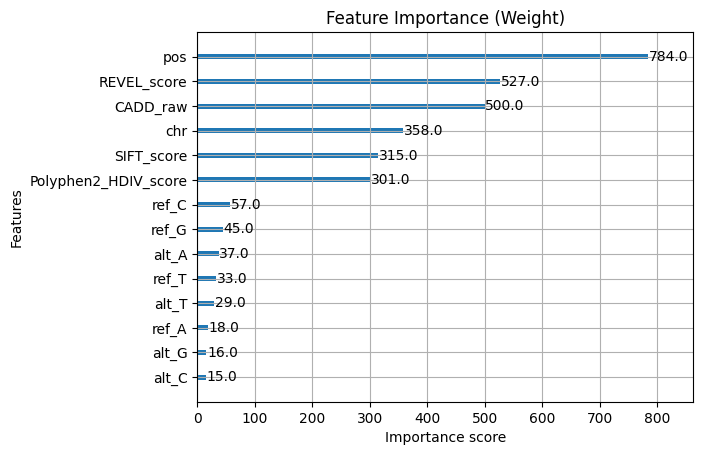

In [25]:
xgb.plot_importance(xgb_base, importance_type='weight', max_num_features=15)
plt.title('Feature Importance (Weight)')

Interestingly, the model seems to make a lot of splits using pos. In my exploratory data analysis, I didn't think that pos was a particularly important feature, so it's surprising to see it take up so much weight. This may be due to the sheer range of position and not an actual reflection of its importance. Out of curiosity, I'm going to try retraining without pos.

# Baseline, no 'pos'

In [34]:
Xtr_no_pos = Xtr.drop(columns=['pos'])
Xte_no_pos = Xte.drop(columns=['pos'])

In [35]:
xgb_no_pos = xgb.XGBClassifier(random_state=0, objective='binary:logistic')
xgb_no_pos.fit(Xtr_no_pos, ytr)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [37]:
# Test
ytr_hat = xgb_no_pos.predict(Xtr_no_pos)
y_hat = xgb_no_pos.predict(Xte_no_pos)
print('TRAIN/TEST ACCURACY:')
print(accuracy_score(yte, y_hat))
print(accuracy_score(ytr, ytr_hat))
print('F1:')
print(f1_score(yte, y_hat))
report = classification_report(yte, y_hat)
print(report)

TRAIN/TEST ACCURACY:
0.926416819012797
0.9880027422303473
F1:
0.8810051736881005
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1502
           1       0.89      0.87      0.88       686

    accuracy                           0.93      2188
   macro avg       0.92      0.91      0.91      2188
weighted avg       0.93      0.93      0.93      2188



Text(0.5, 1.0, 'Feature Importance (Weight)')

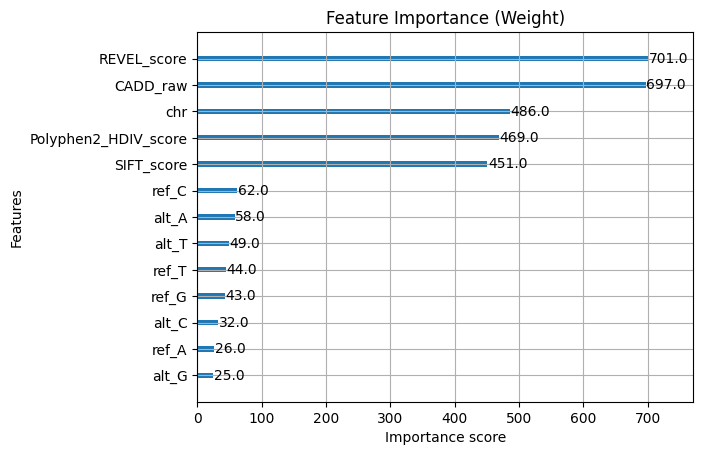

In [39]:
xgb.plot_importance(xgb_no_pos, importance_type='weight', max_num_features=15)
plt.title('Feature Importance (Weight)')

Our performance is slighlty worse, so it seems that pos is actually useful to the model. Going forward, I'll continue with the dataset that uses it.

# Base Model; Imbalanced Class Weights

In [52]:
# Now let's balance the class weights
weight = np.sum(y==0) / np.sum(y==1)
print(weight)
xgb_balanced = xgb.XGBClassifier(random_state=0, objective='binary:logistic', scale_pos_weight=weight)

2.2044522554188637


In [53]:
xgb_balanced.fit(Xtr, ytr)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [56]:
# Test
ytr_hat = xgb_balanced.predict(Xtr)
y_hat = xgb_balanced.predict(Xte)
print('TRAIN/TEST ACCURACY:')
print(accuracy_score(ytr, ytr_hat))
print(accuracy_score(yte, y_hat))
print('F1:')
print(f1_score(yte, y_hat))
report = classification_report(yte, y_hat)
print(report)

TRAIN/TEST ACCURACY:
0.9923446069469836
0.9428702010968921
F1:
0.9094858797972484
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1502
           1       0.90      0.92      0.91       686

    accuracy                           0.94      2188
   macro avg       0.93      0.94      0.93      2188
weighted avg       0.94      0.94      0.94      2188

